In [1]:
from __future__ import print_function
import argparse
import os
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torchvision
import matplotlib.pyplot as plt 
import numpy as np 

from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
from data import get_training_set, get_test_set

%load_ext autoreload
%autoreload 2

In [2]:
class Args:
    batch_size = 64
    test_batch_size = 8
    input_nc = 3
    output_nc = 3
    ngf = 64
    ndf = 64
    epoch_count = 1
    niter = 100
    niter_decay = 100
    lr = 0.0002
    lr_policy = 'lambda'
    lr_decay_iters = 50
    beta1 = 0.5
    cuda = True
    threads = 1
    seed = 123
    lamb = 10
    
opt = Args()
device = torch.device("cuda:0" if opt.cuda else "cpu")

In [3]:
if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

cudnn.benchmark = True

torch.manual_seed(opt.seed)
if opt.cuda:
    torch.cuda.manual_seed(opt.seed)

In [4]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [5]:
print('===> Loading datasets')
train_set = get_training_set()
test_set = get_test_set()
training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, collate_fn=collate_fn, batch_size=opt.batch_size, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, collate_fn=collate_fn, batch_size=opt.test_batch_size, shuffle=False)

===> Loading datasets


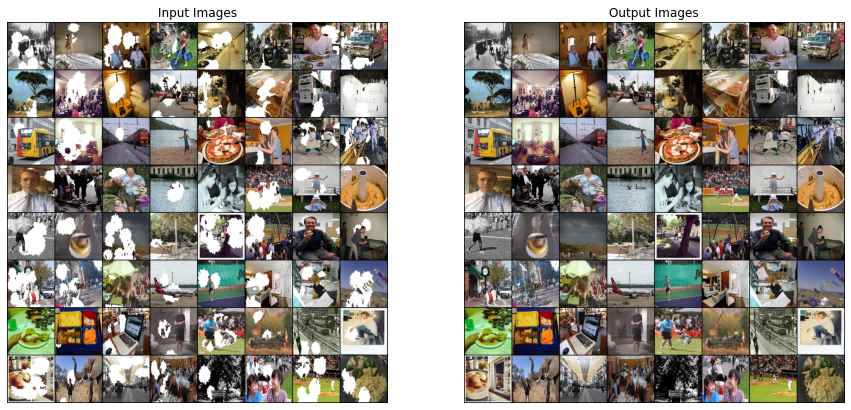

In [6]:
for iteration, batch in enumerate(training_data_loader, 1):
    # forward
    real_a, real_b = batch[0], batch[1]
    
    img_list_a = torchvision.utils.make_grid(real_a.detach().cpu(), padding=2, nrows = 4, normalize=True)
    
    img_list_b = torchvision.utils.make_grid(real_b.detach().cpu(), padding=2, nrows = 4, normalize=True)


    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(img_list_a,(1,2,0)))
    plt.axis("off")
    plt.title("Input Images")
    
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(img_list_b,(1,2,0)))
    plt.axis("off")
    plt.title("Output Images")
    break

In [7]:
print('===> Building models')
net_g = define_G(opt.input_nc, opt.output_nc, opt.ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(opt.input_nc + opt.output_nc, opt.ndf, 'basic', gpu_id=device)

# checkpoint = torch.load("checkpoints/edges2shoes_pretrained/latest_net_G.pth", map_location=device)

# net_g.load_state_dict(checkpoint['model_state_dict'])

criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

optimizer_d = optim.Adam(net_d.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
net_g_scheduler = get_scheduler(optimizer_g, opt)
net_d_scheduler = get_scheduler(optimizer_d, opt)

===> Building models
initialize network with normal
initialize network with normal


In [8]:
net_g = torch.load("checkpoints/netG_model_epoch_1.pth")
net_d = torch.load("checkpoints/netD_model_epoch_1.pth")

In [ ]:
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = net_g(real_a)

        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = net_d.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()
       
        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * opt.lamb
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()

        optimizer_g.step()

        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))

    update_learning_rate(net_g_scheduler, optimizer_g)
    update_learning_rate(net_d_scheduler, optimizer_d)

    # test
    avg_psnr = 0
    for batch in testing_data_loader:
        input, target = batch[0].to(device), batch[1].to(device)

        prediction = net_g(input)
        mse = criterionMSE(prediction, target)
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

    #checkpoint
    if epoch % 1 == 0:
        if not os.path.exists("checkpoint"):
            os.mkdir("checkpoint")
        if not os.path.exists(os.path.join("checkpoint", opt.dataset)):
            os.mkdir(os.path.join("checkpoint", opt.dataset))
        net_g_model_out_path = "checkpoints/netG_model_epoch_{}.pth".format(epoch)
        net_d_model_out_path = "checkpoints/netD_model_epoch_{}.pth".format(epoch)
        torch.save(net_g, net_g_model_out_path)
        torch.save(net_d, net_d_model_out_path)
        print("Checkpoint saved to {}".format("checkpoint" + opt.dataset))

===> Epoch[1](1/13438): Loss_D: 0.2636 Loss_G: 1.5744
===> Epoch[1](2/13438): Loss_D: 0.2592 Loss_G: 1.5204
===> Epoch[1](3/13438): Loss_D: 0.2618 Loss_G: 1.5180
===> Epoch[1](4/13438): Loss_D: 0.2623 Loss_G: 1.4828
===> Epoch[1](5/13438): Loss_D: 0.2650 Loss_G: 1.4803
===> Epoch[1](6/13438): Loss_D: 0.2655 Loss_G: 1.5970
===> Epoch[1](7/13438): Loss_D: 0.2599 Loss_G: 1.5817
===> Epoch[1](8/13438): Loss_D: 0.2621 Loss_G: 1.6858
===> Epoch[1](9/13438): Loss_D: 0.2587 Loss_G: 1.5852
===> Epoch[1](10/13438): Loss_D: 0.2666 Loss_G: 1.5463
===> Epoch[1](11/13438): Loss_D: 0.2652 Loss_G: 1.4840
===> Epoch[1](12/13438): Loss_D: 0.2619 Loss_G: 1.5272
===> Epoch[1](13/13438): Loss_D: 0.2642 Loss_G: 1.6214
===> Epoch[1](14/13438): Loss_D: 0.2639 Loss_G: 1.4472
===> Epoch[1](15/13438): Loss_D: 0.2632 Loss_G: 1.6098
===> Epoch[1](16/13438): Loss_D: 0.2633 Loss_G: 1.5375
===> Epoch[1](17/13438): Loss_D: 0.2639 Loss_G: 1.5500
===> Epoch[1](18/13438): Loss_D: 0.2667 Loss_G: 1.5800
===> Epoch[1](19/13

===> Epoch[1](150/13438): Loss_D: 0.2586 Loss_G: 1.4954
===> Epoch[1](151/13438): Loss_D: 0.2628 Loss_G: 1.5041
===> Epoch[1](152/13438): Loss_D: 0.2668 Loss_G: 1.6098
===> Epoch[1](153/13438): Loss_D: 0.2615 Loss_G: 1.5716
===> Epoch[1](154/13438): Loss_D: 0.2618 Loss_G: 1.5381
===> Epoch[1](155/13438): Loss_D: 0.2641 Loss_G: 1.4833
===> Epoch[1](156/13438): Loss_D: 0.2598 Loss_G: 1.5073
===> Epoch[1](157/13438): Loss_D: 0.2646 Loss_G: 1.5870
===> Epoch[1](158/13438): Loss_D: 0.2624 Loss_G: 1.5454
===> Epoch[1](159/13438): Loss_D: 0.2647 Loss_G: 1.5317
===> Epoch[1](160/13438): Loss_D: 0.2624 Loss_G: 1.5027
===> Epoch[1](161/13438): Loss_D: 0.2662 Loss_G: 1.5816
===> Epoch[1](162/13438): Loss_D: 0.2662 Loss_G: 1.5194
===> Epoch[1](163/13438): Loss_D: 0.2580 Loss_G: 1.6798
===> Epoch[1](164/13438): Loss_D: 0.2650 Loss_G: 1.5351
===> Epoch[1](165/13438): Loss_D: 0.2622 Loss_G: 1.5879
===> Epoch[1](166/13438): Loss_D: 0.2653 Loss_G: 1.7145
===> Epoch[1](167/13438): Loss_D: 0.2624 Loss_G:

===> Epoch[1](297/13438): Loss_D: 0.2619 Loss_G: 1.4905
===> Epoch[1](298/13438): Loss_D: 0.2606 Loss_G: 1.6012
===> Epoch[1](299/13438): Loss_D: 0.2610 Loss_G: 1.4924
===> Epoch[1](300/13438): Loss_D: 0.2658 Loss_G: 1.5303
===> Epoch[1](301/13438): Loss_D: 0.2649 Loss_G: 1.5267
===> Epoch[1](302/13438): Loss_D: 0.2654 Loss_G: 1.5785
===> Epoch[1](303/13438): Loss_D: 0.2629 Loss_G: 1.5308
===> Epoch[1](304/13438): Loss_D: 0.2661 Loss_G: 1.5446
===> Epoch[1](305/13438): Loss_D: 0.2696 Loss_G: 1.5732
===> Epoch[1](306/13438): Loss_D: 0.2614 Loss_G: 1.6287
===> Epoch[1](307/13438): Loss_D: 0.2631 Loss_G: 1.5231
===> Epoch[1](308/13438): Loss_D: 0.2641 Loss_G: 1.4768
===> Epoch[1](309/13438): Loss_D: 0.2599 Loss_G: 1.6692
===> Epoch[1](310/13438): Loss_D: 0.2640 Loss_G: 1.4702
===> Epoch[1](311/13438): Loss_D: 0.2607 Loss_G: 1.3838
===> Epoch[1](312/13438): Loss_D: 0.2566 Loss_G: 1.5766
===> Epoch[1](313/13438): Loss_D: 0.2626 Loss_G: 1.6141
===> Epoch[1](314/13438): Loss_D: 0.2670 Loss_G:

===> Epoch[1](444/13438): Loss_D: 0.2648 Loss_G: 1.5771
===> Epoch[1](445/13438): Loss_D: 0.2628 Loss_G: 1.6338
===> Epoch[1](446/13438): Loss_D: 0.2619 Loss_G: 1.5681
===> Epoch[1](447/13438): Loss_D: 0.2601 Loss_G: 1.5499
===> Epoch[1](448/13438): Loss_D: 0.2664 Loss_G: 1.5476
===> Epoch[1](449/13438): Loss_D: 0.2686 Loss_G: 1.5149
===> Epoch[1](450/13438): Loss_D: 0.2602 Loss_G: 1.5039
===> Epoch[1](451/13438): Loss_D: 0.2691 Loss_G: 1.5997
===> Epoch[1](452/13438): Loss_D: 0.2625 Loss_G: 1.5093
===> Epoch[1](453/13438): Loss_D: 0.2638 Loss_G: 1.5234
===> Epoch[1](454/13438): Loss_D: 0.2613 Loss_G: 1.5276
===> Epoch[1](455/13438): Loss_D: 0.2599 Loss_G: 1.4971
===> Epoch[1](456/13438): Loss_D: 0.2679 Loss_G: 1.5514
===> Epoch[1](457/13438): Loss_D: 0.2574 Loss_G: 1.6414
===> Epoch[1](458/13438): Loss_D: 0.2638 Loss_G: 1.4763
===> Epoch[1](459/13438): Loss_D: 0.2688 Loss_G: 1.5381
===> Epoch[1](460/13438): Loss_D: 0.2676 Loss_G: 1.4630
===> Epoch[1](461/13438): Loss_D: 0.2636 Loss_G:

===> Epoch[1](591/13438): Loss_D: 0.2676 Loss_G: 1.4283
===> Epoch[1](592/13438): Loss_D: 0.2644 Loss_G: 1.5524
===> Epoch[1](593/13438): Loss_D: 0.2625 Loss_G: 1.4905
===> Epoch[1](594/13438): Loss_D: 0.2635 Loss_G: 1.5637
===> Epoch[1](595/13438): Loss_D: 0.2602 Loss_G: 1.5157
===> Epoch[1](596/13438): Loss_D: 0.2646 Loss_G: 1.4718
===> Epoch[1](597/13438): Loss_D: 0.2621 Loss_G: 1.5033
===> Epoch[1](598/13438): Loss_D: 0.2584 Loss_G: 1.4538
===> Epoch[1](599/13438): Loss_D: 0.2697 Loss_G: 1.5858
===> Epoch[1](600/13438): Loss_D: 0.2602 Loss_G: 1.5628
===> Epoch[1](601/13438): Loss_D: 0.2643 Loss_G: 1.5279
===> Epoch[1](602/13438): Loss_D: 0.2643 Loss_G: 1.6272
===> Epoch[1](603/13438): Loss_D: 0.2613 Loss_G: 1.5568
===> Epoch[1](604/13438): Loss_D: 0.2639 Loss_G: 1.5758
===> Epoch[1](605/13438): Loss_D: 0.2639 Loss_G: 1.5724
===> Epoch[1](606/13438): Loss_D: 0.2615 Loss_G: 1.5779
===> Epoch[1](607/13438): Loss_D: 0.2601 Loss_G: 1.6339
===> Epoch[1](608/13438): Loss_D: 0.2642 Loss_G:

===> Epoch[1](738/13438): Loss_D: 0.2634 Loss_G: 1.6697
===> Epoch[1](739/13438): Loss_D: 0.2616 Loss_G: 1.6307
===> Epoch[1](740/13438): Loss_D: 0.2654 Loss_G: 1.5785
===> Epoch[1](741/13438): Loss_D: 0.2628 Loss_G: 1.4982
===> Epoch[1](742/13438): Loss_D: 0.2593 Loss_G: 1.5142
===> Epoch[1](743/13438): Loss_D: 0.2643 Loss_G: 1.5309
===> Epoch[1](744/13438): Loss_D: 0.2643 Loss_G: 1.5274
===> Epoch[1](745/13438): Loss_D: 0.2622 Loss_G: 1.4666
===> Epoch[1](746/13438): Loss_D: 0.2642 Loss_G: 1.4824
===> Epoch[1](747/13438): Loss_D: 0.2683 Loss_G: 1.5667
===> Epoch[1](748/13438): Loss_D: 0.2627 Loss_G: 1.5040
===> Epoch[1](749/13438): Loss_D: 0.2633 Loss_G: 1.4699
===> Epoch[1](750/13438): Loss_D: 0.2679 Loss_G: 1.5531
===> Epoch[1](751/13438): Loss_D: 0.2614 Loss_G: 1.5843
===> Epoch[1](752/13438): Loss_D: 0.2614 Loss_G: 1.5447
===> Epoch[1](753/13438): Loss_D: 0.2626 Loss_G: 1.5912
===> Epoch[1](754/13438): Loss_D: 0.2638 Loss_G: 1.4448
===> Epoch[1](755/13438): Loss_D: 0.2654 Loss_G:

===> Epoch[1](885/13438): Loss_D: 0.2668 Loss_G: 1.5039
===> Epoch[1](886/13438): Loss_D: 0.2624 Loss_G: 1.5116
===> Epoch[1](887/13438): Loss_D: 0.2638 Loss_G: 1.4790
===> Epoch[1](888/13438): Loss_D: 0.2634 Loss_G: 1.5551
===> Epoch[1](889/13438): Loss_D: 0.2629 Loss_G: 1.6372
===> Epoch[1](890/13438): Loss_D: 0.2607 Loss_G: 1.5837
===> Epoch[1](891/13438): Loss_D: 0.2626 Loss_G: 1.5956
===> Epoch[1](892/13438): Loss_D: 0.2652 Loss_G: 1.5371
===> Epoch[1](893/13438): Loss_D: 0.2681 Loss_G: 1.4981
===> Epoch[1](894/13438): Loss_D: 0.2631 Loss_G: 1.5972
===> Epoch[1](895/13438): Loss_D: 0.2607 Loss_G: 1.5205
===> Epoch[1](896/13438): Loss_D: 0.2631 Loss_G: 1.5376
===> Epoch[1](897/13438): Loss_D: 0.2654 Loss_G: 1.6190
===> Epoch[1](898/13438): Loss_D: 0.2591 Loss_G: 1.5319
===> Epoch[1](899/13438): Loss_D: 0.2632 Loss_G: 1.4375
===> Epoch[1](900/13438): Loss_D: 0.2623 Loss_G: 1.4282
===> Epoch[1](901/13438): Loss_D: 0.2621 Loss_G: 1.4292
===> Epoch[1](902/13438): Loss_D: 0.2631 Loss_G:

===> Epoch[1](1031/13438): Loss_D: 0.2640 Loss_G: 1.5122
===> Epoch[1](1032/13438): Loss_D: 0.2652 Loss_G: 1.4869
===> Epoch[1](1033/13438): Loss_D: 0.2626 Loss_G: 1.5820
===> Epoch[1](1034/13438): Loss_D: 0.2637 Loss_G: 1.5856
===> Epoch[1](1035/13438): Loss_D: 0.2623 Loss_G: 1.5471
===> Epoch[1](1036/13438): Loss_D: 0.2649 Loss_G: 1.5920
===> Epoch[1](1037/13438): Loss_D: 0.2663 Loss_G: 1.4606
===> Epoch[1](1038/13438): Loss_D: 0.2634 Loss_G: 1.5997
===> Epoch[1](1039/13438): Loss_D: 0.2641 Loss_G: 1.5981
===> Epoch[1](1040/13438): Loss_D: 0.2606 Loss_G: 1.5291
===> Epoch[1](1041/13438): Loss_D: 0.2613 Loss_G: 1.4897
===> Epoch[1](1042/13438): Loss_D: 0.2608 Loss_G: 1.4960
===> Epoch[1](1043/13438): Loss_D: 0.2634 Loss_G: 1.4917
===> Epoch[1](1044/13438): Loss_D: 0.2684 Loss_G: 1.4885
===> Epoch[1](1045/13438): Loss_D: 0.2620 Loss_G: 1.5350
===> Epoch[1](1046/13438): Loss_D: 0.2610 Loss_G: 1.5374
===> Epoch[1](1047/13438): Loss_D: 0.2689 Loss_G: 1.5447
===> Epoch[1](1048/13438): Loss

===> Epoch[1](1175/13438): Loss_D: 0.2660 Loss_G: 1.6462
===> Epoch[1](1176/13438): Loss_D: 0.2584 Loss_G: 1.6834
===> Epoch[1](1177/13438): Loss_D: 0.2657 Loss_G: 1.5758
===> Epoch[1](1178/13438): Loss_D: 0.2640 Loss_G: 1.5614
===> Epoch[1](1179/13438): Loss_D: 0.2653 Loss_G: 1.5347
===> Epoch[1](1180/13438): Loss_D: 0.2613 Loss_G: 1.4886
===> Epoch[1](1181/13438): Loss_D: 0.2625 Loss_G: 1.5462
===> Epoch[1](1182/13438): Loss_D: 0.2629 Loss_G: 1.5634
===> Epoch[1](1183/13438): Loss_D: 0.2665 Loss_G: 1.6540
===> Epoch[1](1184/13438): Loss_D: 0.2687 Loss_G: 1.5834
===> Epoch[1](1185/13438): Loss_D: 0.2598 Loss_G: 1.5483
===> Epoch[1](1186/13438): Loss_D: 0.2672 Loss_G: 1.5679
===> Epoch[1](1187/13438): Loss_D: 0.2623 Loss_G: 1.4819
===> Epoch[1](1188/13438): Loss_D: 0.2597 Loss_G: 1.4664
===> Epoch[1](1189/13438): Loss_D: 0.2640 Loss_G: 1.5472
===> Epoch[1](1190/13438): Loss_D: 0.2682 Loss_G: 1.4809
===> Epoch[1](1191/13438): Loss_D: 0.2681 Loss_G: 1.5613
===> Epoch[1](1192/13438): Loss

===> Epoch[1](1319/13438): Loss_D: 0.2625 Loss_G: 1.4967
===> Epoch[1](1320/13438): Loss_D: 0.2631 Loss_G: 1.5383
===> Epoch[1](1321/13438): Loss_D: 0.2635 Loss_G: 1.5888
===> Epoch[1](1322/13438): Loss_D: 0.2653 Loss_G: 1.6625
===> Epoch[1](1323/13438): Loss_D: 0.2625 Loss_G: 1.5527
===> Epoch[1](1324/13438): Loss_D: 0.2606 Loss_G: 1.5513
===> Epoch[1](1325/13438): Loss_D: 0.2636 Loss_G: 1.5206
===> Epoch[1](1326/13438): Loss_D: 0.2605 Loss_G: 1.5199
===> Epoch[1](1327/13438): Loss_D: 0.2590 Loss_G: 1.5062
===> Epoch[1](1328/13438): Loss_D: 0.2653 Loss_G: 1.6042
===> Epoch[1](1329/13438): Loss_D: 0.2631 Loss_G: 1.5696
===> Epoch[1](1330/13438): Loss_D: 0.2609 Loss_G: 1.4220
===> Epoch[1](1331/13438): Loss_D: 0.2613 Loss_G: 1.6219
===> Epoch[1](1332/13438): Loss_D: 0.2605 Loss_G: 1.5057
===> Epoch[1](1333/13438): Loss_D: 0.2674 Loss_G: 1.5726
===> Epoch[1](1334/13438): Loss_D: 0.2621 Loss_G: 1.5086
===> Epoch[1](1335/13438): Loss_D: 0.2637 Loss_G: 1.5928
===> Epoch[1](1336/13438): Loss

===> Epoch[1](1463/13438): Loss_D: 0.2607 Loss_G: 1.6686
===> Epoch[1](1464/13438): Loss_D: 0.2654 Loss_G: 1.5430
===> Epoch[1](1465/13438): Loss_D: 0.2632 Loss_G: 1.5696
===> Epoch[1](1466/13438): Loss_D: 0.2666 Loss_G: 1.5440
===> Epoch[1](1467/13438): Loss_D: 0.2633 Loss_G: 1.5295
===> Epoch[1](1468/13438): Loss_D: 0.2648 Loss_G: 1.6184
===> Epoch[1](1469/13438): Loss_D: 0.2644 Loss_G: 1.6308
===> Epoch[1](1470/13438): Loss_D: 0.2619 Loss_G: 1.5129
===> Epoch[1](1471/13438): Loss_D: 0.2642 Loss_G: 1.6609
===> Epoch[1](1472/13438): Loss_D: 0.2610 Loss_G: 1.5011
===> Epoch[1](1473/13438): Loss_D: 0.2632 Loss_G: 1.5376
===> Epoch[1](1474/13438): Loss_D: 0.2655 Loss_G: 1.5190
===> Epoch[1](1475/13438): Loss_D: 0.2646 Loss_G: 1.5621
===> Epoch[1](1476/13438): Loss_D: 0.2641 Loss_G: 1.6025
===> Epoch[1](1477/13438): Loss_D: 0.2680 Loss_G: 1.7131
===> Epoch[1](1478/13438): Loss_D: 0.2613 Loss_G: 1.5437
===> Epoch[1](1479/13438): Loss_D: 0.2613 Loss_G: 1.5147
===> Epoch[1](1480/13438): Loss

===> Epoch[1](1607/13438): Loss_D: 0.2599 Loss_G: 1.5493
===> Epoch[1](1608/13438): Loss_D: 0.2652 Loss_G: 1.6475
===> Epoch[1](1609/13438): Loss_D: 0.2624 Loss_G: 1.4466
===> Epoch[1](1610/13438): Loss_D: 0.2626 Loss_G: 1.5557
===> Epoch[1](1611/13438): Loss_D: 0.2636 Loss_G: 1.5263
===> Epoch[1](1612/13438): Loss_D: 0.2610 Loss_G: 1.6118
===> Epoch[1](1613/13438): Loss_D: 0.2724 Loss_G: 1.5539
===> Epoch[1](1614/13438): Loss_D: 0.2647 Loss_G: 1.4908
===> Epoch[1](1615/13438): Loss_D: 0.2707 Loss_G: 1.5867
===> Epoch[1](1616/13438): Loss_D: 0.2612 Loss_G: 1.7134
===> Epoch[1](1617/13438): Loss_D: 0.2631 Loss_G: 1.3658
===> Epoch[1](1618/13438): Loss_D: 0.2588 Loss_G: 1.6170
===> Epoch[1](1619/13438): Loss_D: 0.2632 Loss_G: 1.6120
===> Epoch[1](1620/13438): Loss_D: 0.2613 Loss_G: 1.4770
===> Epoch[1](1621/13438): Loss_D: 0.2648 Loss_G: 1.5251
===> Epoch[1](1622/13438): Loss_D: 0.2628 Loss_G: 1.7388
===> Epoch[1](1623/13438): Loss_D: 0.2598 Loss_G: 1.5458
===> Epoch[1](1624/13438): Loss

===> Epoch[1](1751/13438): Loss_D: 0.2614 Loss_G: 1.5764
===> Epoch[1](1752/13438): Loss_D: 0.2613 Loss_G: 1.4618
===> Epoch[1](1753/13438): Loss_D: 0.2625 Loss_G: 1.5177
===> Epoch[1](1754/13438): Loss_D: 0.2643 Loss_G: 1.6093
===> Epoch[1](1755/13438): Loss_D: 0.2622 Loss_G: 1.6172
===> Epoch[1](1756/13438): Loss_D: 0.2641 Loss_G: 1.4680
===> Epoch[1](1757/13438): Loss_D: 0.2673 Loss_G: 1.6649
===> Epoch[1](1758/13438): Loss_D: 0.2667 Loss_G: 1.6227
===> Epoch[1](1759/13438): Loss_D: 0.2587 Loss_G: 1.6084
===> Epoch[1](1760/13438): Loss_D: 0.2651 Loss_G: 1.5077
===> Epoch[1](1761/13438): Loss_D: 0.2615 Loss_G: 1.5426
===> Epoch[1](1762/13438): Loss_D: 0.2635 Loss_G: 1.5495
===> Epoch[1](1763/13438): Loss_D: 0.2657 Loss_G: 1.5263
===> Epoch[1](1764/13438): Loss_D: 0.2630 Loss_G: 1.5638
===> Epoch[1](1765/13438): Loss_D: 0.2669 Loss_G: 1.5696
===> Epoch[1](1766/13438): Loss_D: 0.2652 Loss_G: 1.5666
===> Epoch[1](1767/13438): Loss_D: 0.2679 Loss_G: 1.6946
===> Epoch[1](1768/13438): Loss

===> Epoch[1](1895/13438): Loss_D: 0.2614 Loss_G: 1.5166
===> Epoch[1](1896/13438): Loss_D: 0.2665 Loss_G: 1.6473
===> Epoch[1](1897/13438): Loss_D: 0.2642 Loss_G: 1.5140
===> Epoch[1](1898/13438): Loss_D: 0.2652 Loss_G: 1.4736
===> Epoch[1](1899/13438): Loss_D: 0.2647 Loss_G: 1.6038
===> Epoch[1](1900/13438): Loss_D: 0.2619 Loss_G: 1.5529
===> Epoch[1](1901/13438): Loss_D: 0.2608 Loss_G: 1.5306
===> Epoch[1](1902/13438): Loss_D: 0.2623 Loss_G: 1.4495
===> Epoch[1](1903/13438): Loss_D: 0.2614 Loss_G: 1.5614
===> Epoch[1](1904/13438): Loss_D: 0.2642 Loss_G: 1.6140
===> Epoch[1](1905/13438): Loss_D: 0.2639 Loss_G: 1.5143
===> Epoch[1](1906/13438): Loss_D: 0.2643 Loss_G: 1.5880
===> Epoch[1](1907/13438): Loss_D: 0.2624 Loss_G: 1.5199
===> Epoch[1](1908/13438): Loss_D: 0.2669 Loss_G: 1.5704
===> Epoch[1](1909/13438): Loss_D: 0.2638 Loss_G: 1.4803
===> Epoch[1](1910/13438): Loss_D: 0.2594 Loss_G: 1.5555
===> Epoch[1](1911/13438): Loss_D: 0.2626 Loss_G: 1.5974
===> Epoch[1](1912/13438): Loss

===> Epoch[1](2039/13438): Loss_D: 0.2634 Loss_G: 1.6386
===> Epoch[1](2040/13438): Loss_D: 0.2616 Loss_G: 1.5953
===> Epoch[1](2041/13438): Loss_D: 0.2645 Loss_G: 1.5876
===> Epoch[1](2042/13438): Loss_D: 0.2641 Loss_G: 1.5900
===> Epoch[1](2043/13438): Loss_D: 0.2677 Loss_G: 1.6698
===> Epoch[1](2044/13438): Loss_D: 0.2651 Loss_G: 1.4547
===> Epoch[1](2045/13438): Loss_D: 0.2618 Loss_G: 1.5301
===> Epoch[1](2046/13438): Loss_D: 0.2706 Loss_G: 1.6841
===> Epoch[1](2047/13438): Loss_D: 0.2648 Loss_G: 1.5745
===> Epoch[1](2048/13438): Loss_D: 0.2650 Loss_G: 1.6143
===> Epoch[1](2049/13438): Loss_D: 0.2641 Loss_G: 1.6323
===> Epoch[1](2050/13438): Loss_D: 0.2671 Loss_G: 1.4947
===> Epoch[1](2051/13438): Loss_D: 0.2647 Loss_G: 1.5591
===> Epoch[1](2052/13438): Loss_D: 0.2620 Loss_G: 1.5725
===> Epoch[1](2053/13438): Loss_D: 0.2621 Loss_G: 1.5897
===> Epoch[1](2054/13438): Loss_D: 0.2626 Loss_G: 1.6234
===> Epoch[1](2055/13438): Loss_D: 0.2631 Loss_G: 1.5309
===> Epoch[1](2056/13438): Loss

===> Epoch[1](2183/13438): Loss_D: 0.2598 Loss_G: 1.5977
===> Epoch[1](2184/13438): Loss_D: 0.2675 Loss_G: 1.6226
===> Epoch[1](2185/13438): Loss_D: 0.2611 Loss_G: 1.5261
===> Epoch[1](2186/13438): Loss_D: 0.2659 Loss_G: 1.6449
===> Epoch[1](2187/13438): Loss_D: 0.2710 Loss_G: 1.4778
===> Epoch[1](2188/13438): Loss_D: 0.2689 Loss_G: 1.6373
===> Epoch[1](2189/13438): Loss_D: 0.2628 Loss_G: 1.6341
===> Epoch[1](2190/13438): Loss_D: 0.2613 Loss_G: 1.4771
===> Epoch[1](2191/13438): Loss_D: 0.2656 Loss_G: 1.5373
===> Epoch[1](2192/13438): Loss_D: 0.2606 Loss_G: 1.5705
===> Epoch[1](2193/13438): Loss_D: 0.2589 Loss_G: 1.4952
===> Epoch[1](2194/13438): Loss_D: 0.2591 Loss_G: 1.5050
===> Epoch[1](2195/13438): Loss_D: 0.2632 Loss_G: 1.5628
===> Epoch[1](2196/13438): Loss_D: 0.2644 Loss_G: 1.5316
===> Epoch[1](2197/13438): Loss_D: 0.2643 Loss_G: 1.5179
===> Epoch[1](2198/13438): Loss_D: 0.2639 Loss_G: 1.5379
===> Epoch[1](2199/13438): Loss_D: 0.2656 Loss_G: 1.5254
===> Epoch[1](2200/13438): Loss

===> Epoch[1](2327/13438): Loss_D: 0.2605 Loss_G: 1.5051
===> Epoch[1](2328/13438): Loss_D: 0.2643 Loss_G: 1.5575
===> Epoch[1](2329/13438): Loss_D: 0.2663 Loss_G: 1.4433
===> Epoch[1](2330/13438): Loss_D: 0.2619 Loss_G: 1.5072
===> Epoch[1](2331/13438): Loss_D: 0.2639 Loss_G: 1.5771
===> Epoch[1](2332/13438): Loss_D: 0.2622 Loss_G: 1.4610
===> Epoch[1](2333/13438): Loss_D: 0.2586 Loss_G: 1.4600
===> Epoch[1](2334/13438): Loss_D: 0.2651 Loss_G: 1.5241
===> Epoch[1](2335/13438): Loss_D: 0.2655 Loss_G: 1.5630
===> Epoch[1](2336/13438): Loss_D: 0.2629 Loss_G: 1.5293
===> Epoch[1](2337/13438): Loss_D: 0.2662 Loss_G: 1.6556
===> Epoch[1](2338/13438): Loss_D: 0.2661 Loss_G: 1.5550
===> Epoch[1](2339/13438): Loss_D: 0.2599 Loss_G: 1.5226
===> Epoch[1](2340/13438): Loss_D: 0.2615 Loss_G: 1.4862
===> Epoch[1](2341/13438): Loss_D: 0.2651 Loss_G: 1.5642
===> Epoch[1](2342/13438): Loss_D: 0.2592 Loss_G: 1.5205
===> Epoch[1](2343/13438): Loss_D: 0.2637 Loss_G: 1.4982
===> Epoch[1](2344/13438): Loss

===> Epoch[1](2471/13438): Loss_D: 0.2635 Loss_G: 1.5143
===> Epoch[1](2472/13438): Loss_D: 0.2694 Loss_G: 1.5851
===> Epoch[1](2473/13438): Loss_D: 0.2624 Loss_G: 1.6809
===> Epoch[1](2474/13438): Loss_D: 0.2627 Loss_G: 1.6255
===> Epoch[1](2475/13438): Loss_D: 0.2624 Loss_G: 1.5288
===> Epoch[1](2476/13438): Loss_D: 0.2646 Loss_G: 1.4980
===> Epoch[1](2477/13438): Loss_D: 0.2630 Loss_G: 1.5455
===> Epoch[1](2478/13438): Loss_D: 0.2675 Loss_G: 1.6035
===> Epoch[1](2479/13438): Loss_D: 0.2640 Loss_G: 1.6604
===> Epoch[1](2480/13438): Loss_D: 0.2646 Loss_G: 1.5309
===> Epoch[1](2481/13438): Loss_D: 0.2679 Loss_G: 1.5926
===> Epoch[1](2482/13438): Loss_D: 0.2606 Loss_G: 1.4887
===> Epoch[1](2483/13438): Loss_D: 0.2616 Loss_G: 1.5488
===> Epoch[1](2484/13438): Loss_D: 0.2652 Loss_G: 1.4812
===> Epoch[1](2485/13438): Loss_D: 0.2599 Loss_G: 1.4970
===> Epoch[1](2486/13438): Loss_D: 0.2665 Loss_G: 1.4788
===> Epoch[1](2487/13438): Loss_D: 0.2625 Loss_G: 1.5536
===> Epoch[1](2488/13438): Loss

===> Epoch[1](2615/13438): Loss_D: 0.2710 Loss_G: 1.5508
===> Epoch[1](2616/13438): Loss_D: 0.2631 Loss_G: 1.5471
===> Epoch[1](2617/13438): Loss_D: 0.2653 Loss_G: 1.5418
===> Epoch[1](2618/13438): Loss_D: 0.2633 Loss_G: 1.5045
===> Epoch[1](2619/13438): Loss_D: 0.2623 Loss_G: 1.6152
===> Epoch[1](2620/13438): Loss_D: 0.2642 Loss_G: 1.5627
===> Epoch[1](2621/13438): Loss_D: 0.2633 Loss_G: 1.4907
===> Epoch[1](2622/13438): Loss_D: 0.2618 Loss_G: 1.5228
===> Epoch[1](2623/13438): Loss_D: 0.2639 Loss_G: 1.5131
===> Epoch[1](2624/13438): Loss_D: 0.2630 Loss_G: 1.5562
===> Epoch[1](2625/13438): Loss_D: 0.2639 Loss_G: 1.5896
===> Epoch[1](2626/13438): Loss_D: 0.2632 Loss_G: 1.5182
===> Epoch[1](2627/13438): Loss_D: 0.2651 Loss_G: 1.5845
===> Epoch[1](2628/13438): Loss_D: 0.2626 Loss_G: 1.4310
===> Epoch[1](2629/13438): Loss_D: 0.2660 Loss_G: 1.6298
===> Epoch[1](2630/13438): Loss_D: 0.2648 Loss_G: 1.4484
===> Epoch[1](2631/13438): Loss_D: 0.2614 Loss_G: 1.6239
===> Epoch[1](2632/13438): Loss

===> Epoch[1](2759/13438): Loss_D: 0.2611 Loss_G: 1.5300
===> Epoch[1](2760/13438): Loss_D: 0.2618 Loss_G: 1.4954
===> Epoch[1](2761/13438): Loss_D: 0.2611 Loss_G: 1.5739
===> Epoch[1](2762/13438): Loss_D: 0.2620 Loss_G: 1.5000
===> Epoch[1](2763/13438): Loss_D: 0.2648 Loss_G: 1.5517
===> Epoch[1](2764/13438): Loss_D: 0.2666 Loss_G: 1.5362
===> Epoch[1](2765/13438): Loss_D: 0.2647 Loss_G: 1.6361
===> Epoch[1](2766/13438): Loss_D: 0.2629 Loss_G: 1.5700
===> Epoch[1](2767/13438): Loss_D: 0.2635 Loss_G: 1.4595
===> Epoch[1](2768/13438): Loss_D: 0.2662 Loss_G: 1.5121
===> Epoch[1](2769/13438): Loss_D: 0.2610 Loss_G: 1.4795
===> Epoch[1](2770/13438): Loss_D: 0.2629 Loss_G: 1.4756
===> Epoch[1](2771/13438): Loss_D: 0.2614 Loss_G: 1.5375
===> Epoch[1](2772/13438): Loss_D: 0.2673 Loss_G: 1.5756
===> Epoch[1](2773/13438): Loss_D: 0.2637 Loss_G: 1.5403
===> Epoch[1](2774/13438): Loss_D: 0.2622 Loss_G: 1.5899
===> Epoch[1](2775/13438): Loss_D: 0.2643 Loss_G: 1.5461
===> Epoch[1](2776/13438): Loss

===> Epoch[1](2903/13438): Loss_D: 0.2606 Loss_G: 1.5675
===> Epoch[1](2904/13438): Loss_D: 0.2629 Loss_G: 1.6093
===> Epoch[1](2905/13438): Loss_D: 0.2615 Loss_G: 1.4705
===> Epoch[1](2906/13438): Loss_D: 0.2625 Loss_G: 1.5578
===> Epoch[1](2907/13438): Loss_D: 0.2691 Loss_G: 1.5411
===> Epoch[1](2908/13438): Loss_D: 0.2582 Loss_G: 1.5566
===> Epoch[1](2909/13438): Loss_D: 0.2683 Loss_G: 1.6244
===> Epoch[1](2910/13438): Loss_D: 0.2659 Loss_G: 1.5174
===> Epoch[1](2911/13438): Loss_D: 0.2696 Loss_G: 1.7187
===> Epoch[1](2912/13438): Loss_D: 0.2662 Loss_G: 1.6582
===> Epoch[1](2913/13438): Loss_D: 0.2666 Loss_G: 1.5934
===> Epoch[1](2914/13438): Loss_D: 0.2677 Loss_G: 1.5756
===> Epoch[1](2915/13438): Loss_D: 0.2621 Loss_G: 1.4747
===> Epoch[1](2916/13438): Loss_D: 0.2581 Loss_G: 1.5775
===> Epoch[1](2917/13438): Loss_D: 0.2651 Loss_G: 1.6704
===> Epoch[1](2918/13438): Loss_D: 0.2668 Loss_G: 1.4996
===> Epoch[1](2919/13438): Loss_D: 0.2633 Loss_G: 1.6240
===> Epoch[1](2920/13438): Loss

===> Epoch[1](3047/13438): Loss_D: 0.2678 Loss_G: 1.4848
===> Epoch[1](3048/13438): Loss_D: 0.2646 Loss_G: 1.6151
===> Epoch[1](3049/13438): Loss_D: 0.2666 Loss_G: 1.5876
===> Epoch[1](3050/13438): Loss_D: 0.2613 Loss_G: 1.5740
===> Epoch[1](3051/13438): Loss_D: 0.2669 Loss_G: 1.6213
===> Epoch[1](3052/13438): Loss_D: 0.2642 Loss_G: 1.5450
===> Epoch[1](3053/13438): Loss_D: 0.2606 Loss_G: 1.5043
===> Epoch[1](3054/13438): Loss_D: 0.2620 Loss_G: 1.5638
===> Epoch[1](3055/13438): Loss_D: 0.2669 Loss_G: 1.6621
===> Epoch[1](3056/13438): Loss_D: 0.2600 Loss_G: 1.5199
===> Epoch[1](3057/13438): Loss_D: 0.2640 Loss_G: 1.5677
===> Epoch[1](3058/13438): Loss_D: 0.2637 Loss_G: 1.6007
===> Epoch[1](3059/13438): Loss_D: 0.2628 Loss_G: 1.4802
===> Epoch[1](3060/13438): Loss_D: 0.2683 Loss_G: 1.5412
===> Epoch[1](3061/13438): Loss_D: 0.2638 Loss_G: 1.5891
===> Epoch[1](3062/13438): Loss_D: 0.2637 Loss_G: 1.5692
===> Epoch[1](3063/13438): Loss_D: 0.2608 Loss_G: 1.4998
===> Epoch[1](3064/13438): Loss

===> Epoch[1](3191/13438): Loss_D: 0.2663 Loss_G: 1.5734
===> Epoch[1](3192/13438): Loss_D: 0.2637 Loss_G: 1.5386
===> Epoch[1](3193/13438): Loss_D: 0.2628 Loss_G: 1.6054
===> Epoch[1](3194/13438): Loss_D: 0.2637 Loss_G: 1.5125
===> Epoch[1](3195/13438): Loss_D: 0.2638 Loss_G: 1.5666
===> Epoch[1](3196/13438): Loss_D: 0.2585 Loss_G: 1.6936
===> Epoch[1](3197/13438): Loss_D: 0.2625 Loss_G: 1.6271
===> Epoch[1](3198/13438): Loss_D: 0.2618 Loss_G: 1.4900
===> Epoch[1](3199/13438): Loss_D: 0.2625 Loss_G: 1.6249
===> Epoch[1](3200/13438): Loss_D: 0.2647 Loss_G: 1.5194
===> Epoch[1](3201/13438): Loss_D: 0.2611 Loss_G: 1.5062
===> Epoch[1](3202/13438): Loss_D: 0.2669 Loss_G: 1.5210
===> Epoch[1](3203/13438): Loss_D: 0.2652 Loss_G: 1.5087
===> Epoch[1](3204/13438): Loss_D: 0.2626 Loss_G: 1.6075
===> Epoch[1](3205/13438): Loss_D: 0.2638 Loss_G: 1.4652
===> Epoch[1](3206/13438): Loss_D: 0.2630 Loss_G: 1.7097
===> Epoch[1](3207/13438): Loss_D: 0.2611 Loss_G: 1.4945
===> Epoch[1](3208/13438): Loss

===> Epoch[1](3335/13438): Loss_D: 0.2671 Loss_G: 1.6024
===> Epoch[1](3336/13438): Loss_D: 0.2688 Loss_G: 1.6529
===> Epoch[1](3337/13438): Loss_D: 0.2601 Loss_G: 1.6241
===> Epoch[1](3338/13438): Loss_D: 0.2648 Loss_G: 1.5928
===> Epoch[1](3339/13438): Loss_D: 0.2630 Loss_G: 1.5899
===> Epoch[1](3340/13438): Loss_D: 0.2650 Loss_G: 1.4896
===> Epoch[1](3341/13438): Loss_D: 0.2652 Loss_G: 1.5969
===> Epoch[1](3342/13438): Loss_D: 0.2668 Loss_G: 1.5798
===> Epoch[1](3343/13438): Loss_D: 0.2684 Loss_G: 1.5043
===> Epoch[1](3344/13438): Loss_D: 0.2657 Loss_G: 1.6090
===> Epoch[1](3345/13438): Loss_D: 0.2629 Loss_G: 1.6901
===> Epoch[1](3346/13438): Loss_D: 0.2609 Loss_G: 1.5057
===> Epoch[1](3347/13438): Loss_D: 0.2630 Loss_G: 1.4972
===> Epoch[1](3348/13438): Loss_D: 0.2645 Loss_G: 1.5142
===> Epoch[1](3349/13438): Loss_D: 0.2594 Loss_G: 1.4351
===> Epoch[1](3350/13438): Loss_D: 0.2618 Loss_G: 1.6522
===> Epoch[1](3351/13438): Loss_D: 0.2648 Loss_G: 1.4223
===> Epoch[1](3352/13438): Loss

===> Epoch[1](3479/13438): Loss_D: 0.2635 Loss_G: 1.5742
===> Epoch[1](3480/13438): Loss_D: 0.2628 Loss_G: 1.5682
===> Epoch[1](3481/13438): Loss_D: 0.2634 Loss_G: 1.6316
===> Epoch[1](3482/13438): Loss_D: 0.2662 Loss_G: 1.8274
===> Epoch[1](3483/13438): Loss_D: 0.2591 Loss_G: 1.5346
===> Epoch[1](3484/13438): Loss_D: 0.2614 Loss_G: 1.5186
===> Epoch[1](3485/13438): Loss_D: 0.2701 Loss_G: 1.4852
===> Epoch[1](3486/13438): Loss_D: 0.2643 Loss_G: 1.5957
===> Epoch[1](3487/13438): Loss_D: 0.2628 Loss_G: 1.5549
===> Epoch[1](3488/13438): Loss_D: 0.2624 Loss_G: 1.7116
===> Epoch[1](3489/13438): Loss_D: 0.2662 Loss_G: 1.5042
===> Epoch[1](3490/13438): Loss_D: 0.2614 Loss_G: 1.5264
===> Epoch[1](3491/13438): Loss_D: 0.2627 Loss_G: 1.6278
===> Epoch[1](3492/13438): Loss_D: 0.2631 Loss_G: 1.6039
===> Epoch[1](3493/13438): Loss_D: 0.2644 Loss_G: 1.5117
===> Epoch[1](3494/13438): Loss_D: 0.2638 Loss_G: 1.5575
===> Epoch[1](3495/13438): Loss_D: 0.2614 Loss_G: 1.5877
===> Epoch[1](3496/13438): Loss

===> Epoch[1](3623/13438): Loss_D: 0.2604 Loss_G: 1.4672
===> Epoch[1](3624/13438): Loss_D: 0.2603 Loss_G: 1.5200
===> Epoch[1](3625/13438): Loss_D: 0.2643 Loss_G: 1.5591
===> Epoch[1](3626/13438): Loss_D: 0.2657 Loss_G: 1.5836
===> Epoch[1](3627/13438): Loss_D: 0.2641 Loss_G: 1.5201
===> Epoch[1](3628/13438): Loss_D: 0.2603 Loss_G: 1.5849
===> Epoch[1](3629/13438): Loss_D: 0.2656 Loss_G: 1.5487
===> Epoch[1](3630/13438): Loss_D: 0.2661 Loss_G: 1.4906
===> Epoch[1](3631/13438): Loss_D: 0.2615 Loss_G: 1.5584
===> Epoch[1](3632/13438): Loss_D: 0.2678 Loss_G: 1.4778
===> Epoch[1](3633/13438): Loss_D: 0.2635 Loss_G: 1.6031
===> Epoch[1](3634/13438): Loss_D: 0.2662 Loss_G: 1.5782
===> Epoch[1](3635/13438): Loss_D: 0.2650 Loss_G: 1.5796
===> Epoch[1](3636/13438): Loss_D: 0.2619 Loss_G: 1.5897
===> Epoch[1](3637/13438): Loss_D: 0.2628 Loss_G: 1.5161
===> Epoch[1](3638/13438): Loss_D: 0.2642 Loss_G: 1.5192
===> Epoch[1](3639/13438): Loss_D: 0.2605 Loss_G: 1.4430
===> Epoch[1](3640/13438): Loss

===> Epoch[1](3767/13438): Loss_D: 0.2633 Loss_G: 1.6731
===> Epoch[1](3768/13438): Loss_D: 0.2628 Loss_G: 1.5346
===> Epoch[1](3769/13438): Loss_D: 0.2586 Loss_G: 1.5419
===> Epoch[1](3770/13438): Loss_D: 0.2648 Loss_G: 1.5414
===> Epoch[1](3771/13438): Loss_D: 0.2717 Loss_G: 1.5061
===> Epoch[1](3772/13438): Loss_D: 0.2624 Loss_G: 1.6206
===> Epoch[1](3773/13438): Loss_D: 0.2654 Loss_G: 1.4699
===> Epoch[1](3774/13438): Loss_D: 0.2638 Loss_G: 1.4877
===> Epoch[1](3775/13438): Loss_D: 0.2607 Loss_G: 1.4806
===> Epoch[1](3776/13438): Loss_D: 0.2625 Loss_G: 1.6352
===> Epoch[1](3777/13438): Loss_D: 0.2604 Loss_G: 1.7358
===> Epoch[1](3778/13438): Loss_D: 0.2682 Loss_G: 1.5444
===> Epoch[1](3779/13438): Loss_D: 0.2676 Loss_G: 1.4998
===> Epoch[1](3780/13438): Loss_D: 0.2636 Loss_G: 1.5592
===> Epoch[1](3781/13438): Loss_D: 0.2667 Loss_G: 1.5263
===> Epoch[1](3782/13438): Loss_D: 0.2614 Loss_G: 1.5149
===> Epoch[1](3783/13438): Loss_D: 0.2633 Loss_G: 1.5504
===> Epoch[1](3784/13438): Loss

===> Epoch[1](3911/13438): Loss_D: 0.2649 Loss_G: 1.6557
===> Epoch[1](3912/13438): Loss_D: 0.2664 Loss_G: 1.6262
===> Epoch[1](3913/13438): Loss_D: 0.2661 Loss_G: 1.4963
===> Epoch[1](3914/13438): Loss_D: 0.2629 Loss_G: 1.4860
===> Epoch[1](3915/13438): Loss_D: 0.2688 Loss_G: 1.5449
===> Epoch[1](3916/13438): Loss_D: 0.2640 Loss_G: 1.5156
===> Epoch[1](3917/13438): Loss_D: 0.2647 Loss_G: 1.5641
===> Epoch[1](3918/13438): Loss_D: 0.2647 Loss_G: 1.5196
===> Epoch[1](3919/13438): Loss_D: 0.2657 Loss_G: 1.5269
===> Epoch[1](3920/13438): Loss_D: 0.2646 Loss_G: 1.4824
===> Epoch[1](3921/13438): Loss_D: 0.2637 Loss_G: 1.5969
===> Epoch[1](3922/13438): Loss_D: 0.2636 Loss_G: 1.4785
===> Epoch[1](3923/13438): Loss_D: 0.2660 Loss_G: 1.4676
===> Epoch[1](3924/13438): Loss_D: 0.2584 Loss_G: 1.5174
===> Epoch[1](3925/13438): Loss_D: 0.2653 Loss_G: 1.6052
===> Epoch[1](3926/13438): Loss_D: 0.2657 Loss_G: 1.6778
===> Epoch[1](3927/13438): Loss_D: 0.2618 Loss_G: 1.5042
===> Epoch[1](3928/13438): Loss

===> Epoch[1](4055/13438): Loss_D: 0.2658 Loss_G: 1.4542
===> Epoch[1](4056/13438): Loss_D: 0.2659 Loss_G: 1.4919
===> Epoch[1](4057/13438): Loss_D: 0.2639 Loss_G: 1.5353
===> Epoch[1](4058/13438): Loss_D: 0.2596 Loss_G: 1.4205
===> Epoch[1](4059/13438): Loss_D: 0.2633 Loss_G: 1.5581
===> Epoch[1](4060/13438): Loss_D: 0.2616 Loss_G: 1.6374
===> Epoch[1](4061/13438): Loss_D: 0.2663 Loss_G: 1.6122
===> Epoch[1](4062/13438): Loss_D: 0.2632 Loss_G: 1.4983
===> Epoch[1](4063/13438): Loss_D: 0.2640 Loss_G: 1.5963
===> Epoch[1](4064/13438): Loss_D: 0.2661 Loss_G: 1.4996
===> Epoch[1](4065/13438): Loss_D: 0.2662 Loss_G: 1.5548
===> Epoch[1](4066/13438): Loss_D: 0.2665 Loss_G: 1.5632
===> Epoch[1](4067/13438): Loss_D: 0.2662 Loss_G: 1.5631
===> Epoch[1](4068/13438): Loss_D: 0.2668 Loss_G: 1.4888
===> Epoch[1](4069/13438): Loss_D: 0.2641 Loss_G: 1.5317
===> Epoch[1](4070/13438): Loss_D: 0.2620 Loss_G: 1.5951
===> Epoch[1](4071/13438): Loss_D: 0.2676 Loss_G: 1.4408
===> Epoch[1](4072/13438): Loss

===> Epoch[1](4199/13438): Loss_D: 0.2604 Loss_G: 1.5718
===> Epoch[1](4200/13438): Loss_D: 0.2617 Loss_G: 1.5787
===> Epoch[1](4201/13438): Loss_D: 0.2671 Loss_G: 1.6273
===> Epoch[1](4202/13438): Loss_D: 0.2662 Loss_G: 1.4630
===> Epoch[1](4203/13438): Loss_D: 0.2624 Loss_G: 1.5635
===> Epoch[1](4204/13438): Loss_D: 0.2625 Loss_G: 1.4275
===> Epoch[1](4205/13438): Loss_D: 0.2659 Loss_G: 1.5694
===> Epoch[1](4206/13438): Loss_D: 0.2639 Loss_G: 1.5961
===> Epoch[1](4207/13438): Loss_D: 0.2599 Loss_G: 1.5516
===> Epoch[1](4208/13438): Loss_D: 0.2629 Loss_G: 1.6488
===> Epoch[1](4209/13438): Loss_D: 0.2637 Loss_G: 1.5183
===> Epoch[1](4210/13438): Loss_D: 0.2652 Loss_G: 1.5131
===> Epoch[1](4211/13438): Loss_D: 0.2603 Loss_G: 1.6159
===> Epoch[1](4212/13438): Loss_D: 0.2643 Loss_G: 1.5477
===> Epoch[1](4213/13438): Loss_D: 0.2656 Loss_G: 1.6053
===> Epoch[1](4214/13438): Loss_D: 0.2616 Loss_G: 1.6663
===> Epoch[1](4215/13438): Loss_D: 0.2593 Loss_G: 1.5066
===> Epoch[1](4216/13438): Loss

===> Epoch[1](4343/13438): Loss_D: 0.2612 Loss_G: 1.5368
===> Epoch[1](4344/13438): Loss_D: 0.2641 Loss_G: 1.4069
===> Epoch[1](4345/13438): Loss_D: 0.2675 Loss_G: 1.5561
===> Epoch[1](4346/13438): Loss_D: 0.2606 Loss_G: 1.6728
===> Epoch[1](4347/13438): Loss_D: 0.2645 Loss_G: 1.6175
===> Epoch[1](4348/13438): Loss_D: 0.2660 Loss_G: 1.5202
===> Epoch[1](4349/13438): Loss_D: 0.2615 Loss_G: 1.6654
===> Epoch[1](4350/13438): Loss_D: 0.2618 Loss_G: 1.5628
===> Epoch[1](4351/13438): Loss_D: 0.2646 Loss_G: 1.5783
===> Epoch[1](4352/13438): Loss_D: 0.2631 Loss_G: 1.5755
===> Epoch[1](4353/13438): Loss_D: 0.2614 Loss_G: 1.5049
===> Epoch[1](4354/13438): Loss_D: 0.2658 Loss_G: 1.5480
===> Epoch[1](4355/13438): Loss_D: 0.2623 Loss_G: 1.5200
===> Epoch[1](4356/13438): Loss_D: 0.2598 Loss_G: 1.5502
===> Epoch[1](4357/13438): Loss_D: 0.2587 Loss_G: 1.5216
===> Epoch[1](4358/13438): Loss_D: 0.2610 Loss_G: 1.5195
===> Epoch[1](4359/13438): Loss_D: 0.2627 Loss_G: 1.4213
===> Epoch[1](4360/13438): Loss

===> Epoch[1](4487/13438): Loss_D: 0.2587 Loss_G: 1.5427
===> Epoch[1](4488/13438): Loss_D: 0.2666 Loss_G: 1.4939
===> Epoch[1](4489/13438): Loss_D: 0.2637 Loss_G: 1.4629
===> Epoch[1](4490/13438): Loss_D: 0.2732 Loss_G: 1.5991
===> Epoch[1](4491/13438): Loss_D: 0.2651 Loss_G: 1.4656
===> Epoch[1](4492/13438): Loss_D: 0.2670 Loss_G: 1.4272
===> Epoch[1](4493/13438): Loss_D: 0.2671 Loss_G: 1.5684
===> Epoch[1](4494/13438): Loss_D: 0.2591 Loss_G: 1.5945
===> Epoch[1](4495/13438): Loss_D: 0.2683 Loss_G: 1.6164
===> Epoch[1](4496/13438): Loss_D: 0.2640 Loss_G: 1.5507
===> Epoch[1](4497/13438): Loss_D: 0.2638 Loss_G: 1.5351
===> Epoch[1](4498/13438): Loss_D: 0.2617 Loss_G: 1.6230
===> Epoch[1](4499/13438): Loss_D: 0.2642 Loss_G: 1.5615
===> Epoch[1](4500/13438): Loss_D: 0.2618 Loss_G: 1.5115
===> Epoch[1](4501/13438): Loss_D: 0.2643 Loss_G: 1.4931
===> Epoch[1](4502/13438): Loss_D: 0.2634 Loss_G: 1.4804
===> Epoch[1](4503/13438): Loss_D: 0.2641 Loss_G: 1.4671
===> Epoch[1](4504/13438): Loss

===> Epoch[1](4641/13438): Loss_D: 0.2608 Loss_G: 1.5256
===> Epoch[1](4642/13438): Loss_D: 0.2659 Loss_G: 1.6653
===> Epoch[1](4643/13438): Loss_D: 0.2619 Loss_G: 1.4861
===> Epoch[1](4644/13438): Loss_D: 0.2609 Loss_G: 1.4824
===> Epoch[1](4645/13438): Loss_D: 0.2658 Loss_G: 1.5045
===> Epoch[1](4646/13438): Loss_D: 0.2630 Loss_G: 1.6121
===> Epoch[1](4647/13438): Loss_D: 0.2668 Loss_G: 1.4800
===> Epoch[1](4648/13438): Loss_D: 0.2639 Loss_G: 1.4716
===> Epoch[1](4649/13438): Loss_D: 0.2637 Loss_G: 1.5339
===> Epoch[1](4650/13438): Loss_D: 0.2610 Loss_G: 1.4977
===> Epoch[1](4651/13438): Loss_D: 0.2616 Loss_G: 1.5768
===> Epoch[1](4652/13438): Loss_D: 0.2689 Loss_G: 1.4314
===> Epoch[1](4653/13438): Loss_D: 0.2667 Loss_G: 1.6416
===> Epoch[1](4654/13438): Loss_D: 0.2628 Loss_G: 1.6713
===> Epoch[1](4655/13438): Loss_D: 0.2653 Loss_G: 1.5475
===> Epoch[1](4656/13438): Loss_D: 0.2655 Loss_G: 1.5107
===> Epoch[1](4657/13438): Loss_D: 0.2623 Loss_G: 1.6490
===> Epoch[1](4658/13438): Loss

===> Epoch[1](4785/13438): Loss_D: 0.2602 Loss_G: 1.6376
===> Epoch[1](4786/13438): Loss_D: 0.2673 Loss_G: 1.4829
===> Epoch[1](4787/13438): Loss_D: 0.2644 Loss_G: 1.6047
===> Epoch[1](4788/13438): Loss_D: 0.2633 Loss_G: 1.5908
===> Epoch[1](4789/13438): Loss_D: 0.2611 Loss_G: 1.6693
===> Epoch[1](4790/13438): Loss_D: 0.2667 Loss_G: 1.5202
===> Epoch[1](4791/13438): Loss_D: 0.2611 Loss_G: 1.5683
===> Epoch[1](4792/13438): Loss_D: 0.2586 Loss_G: 1.6080
===> Epoch[1](4793/13438): Loss_D: 0.2636 Loss_G: 1.5140
===> Epoch[1](4794/13438): Loss_D: 0.2651 Loss_G: 1.5296
===> Epoch[1](4795/13438): Loss_D: 0.2623 Loss_G: 1.4682
===> Epoch[1](4796/13438): Loss_D: 0.2627 Loss_G: 1.5513
===> Epoch[1](4797/13438): Loss_D: 0.2601 Loss_G: 1.5238
===> Epoch[1](4798/13438): Loss_D: 0.2628 Loss_G: 1.6157
===> Epoch[1](4799/13438): Loss_D: 0.2637 Loss_G: 1.5258
===> Epoch[1](4800/13438): Loss_D: 0.2649 Loss_G: 1.6240
===> Epoch[1](4801/13438): Loss_D: 0.2638 Loss_G: 1.4814
===> Epoch[1](4802/13438): Loss

===> Epoch[1](4929/13438): Loss_D: 0.2627 Loss_G: 1.4561
===> Epoch[1](4930/13438): Loss_D: 0.2624 Loss_G: 1.4872
===> Epoch[1](4931/13438): Loss_D: 0.2604 Loss_G: 1.5785
===> Epoch[1](4932/13438): Loss_D: 0.2686 Loss_G: 1.6797
===> Epoch[1](4933/13438): Loss_D: 0.2598 Loss_G: 1.5637
===> Epoch[1](4934/13438): Loss_D: 0.2668 Loss_G: 1.5067
===> Epoch[1](4935/13438): Loss_D: 0.2642 Loss_G: 1.5711
===> Epoch[1](4936/13438): Loss_D: 0.2614 Loss_G: 1.5309
===> Epoch[1](4937/13438): Loss_D: 0.2603 Loss_G: 1.5029
===> Epoch[1](4938/13438): Loss_D: 0.2659 Loss_G: 1.4724
===> Epoch[1](4939/13438): Loss_D: 0.2615 Loss_G: 1.5624
===> Epoch[1](4940/13438): Loss_D: 0.2688 Loss_G: 1.7025
===> Epoch[1](4941/13438): Loss_D: 0.2677 Loss_G: 1.5183
===> Epoch[1](4942/13438): Loss_D: 0.2611 Loss_G: 1.5431
===> Epoch[1](4943/13438): Loss_D: 0.2587 Loss_G: 1.5861
===> Epoch[1](4944/13438): Loss_D: 0.2586 Loss_G: 1.5449
===> Epoch[1](4945/13438): Loss_D: 0.2609 Loss_G: 1.4801
===> Epoch[1](4946/13438): Loss

===> Epoch[1](5073/13438): Loss_D: 0.2619 Loss_G: 1.6647
===> Epoch[1](5074/13438): Loss_D: 0.2633 Loss_G: 1.6851
===> Epoch[1](5075/13438): Loss_D: 0.2675 Loss_G: 1.5323
===> Epoch[1](5076/13438): Loss_D: 0.2626 Loss_G: 1.5608
===> Epoch[1](5077/13438): Loss_D: 0.2617 Loss_G: 1.5902
===> Epoch[1](5078/13438): Loss_D: 0.2642 Loss_G: 1.5519
===> Epoch[1](5079/13438): Loss_D: 0.2607 Loss_G: 1.6032
===> Epoch[1](5080/13438): Loss_D: 0.2640 Loss_G: 1.5447
===> Epoch[1](5081/13438): Loss_D: 0.2633 Loss_G: 1.5082
===> Epoch[1](5082/13438): Loss_D: 0.2620 Loss_G: 1.5307
===> Epoch[1](5083/13438): Loss_D: 0.2624 Loss_G: 1.5230
===> Epoch[1](5084/13438): Loss_D: 0.2638 Loss_G: 1.6158
===> Epoch[1](5085/13438): Loss_D: 0.2634 Loss_G: 1.6202
===> Epoch[1](5086/13438): Loss_D: 0.2631 Loss_G: 1.4844
===> Epoch[1](5087/13438): Loss_D: 0.2646 Loss_G: 1.5288
===> Epoch[1](5088/13438): Loss_D: 0.2691 Loss_G: 1.6332
===> Epoch[1](5089/13438): Loss_D: 0.2627 Loss_G: 1.5545
===> Epoch[1](5090/13438): Loss

===> Epoch[1](5217/13438): Loss_D: 0.2654 Loss_G: 1.5566
===> Epoch[1](5218/13438): Loss_D: 0.2662 Loss_G: 1.3909
===> Epoch[1](5219/13438): Loss_D: 0.2649 Loss_G: 1.5888
===> Epoch[1](5220/13438): Loss_D: 0.2618 Loss_G: 1.5273
===> Epoch[1](5221/13438): Loss_D: 0.2642 Loss_G: 1.6789
===> Epoch[1](5222/13438): Loss_D: 0.2645 Loss_G: 1.6574
===> Epoch[1](5223/13438): Loss_D: 0.2639 Loss_G: 1.5526
===> Epoch[1](5224/13438): Loss_D: 0.2619 Loss_G: 1.5464
===> Epoch[1](5225/13438): Loss_D: 0.2658 Loss_G: 1.5881
===> Epoch[1](5226/13438): Loss_D: 0.2694 Loss_G: 1.5791
===> Epoch[1](5227/13438): Loss_D: 0.2658 Loss_G: 1.4687
===> Epoch[1](5228/13438): Loss_D: 0.2625 Loss_G: 1.4713
===> Epoch[1](5229/13438): Loss_D: 0.2627 Loss_G: 1.5228
===> Epoch[1](5230/13438): Loss_D: 0.2671 Loss_G: 1.5621
===> Epoch[1](5231/13438): Loss_D: 0.2653 Loss_G: 1.6359
===> Epoch[1](5232/13438): Loss_D: 0.2627 Loss_G: 1.5079
===> Epoch[1](5233/13438): Loss_D: 0.2663 Loss_G: 1.5977
===> Epoch[1](5234/13438): Loss

===> Epoch[1](5361/13438): Loss_D: 0.2691 Loss_G: 1.7197
===> Epoch[1](5362/13438): Loss_D: 0.2608 Loss_G: 1.5936
===> Epoch[1](5363/13438): Loss_D: 0.2646 Loss_G: 1.5253
===> Epoch[1](5364/13438): Loss_D: 0.2635 Loss_G: 1.6741
===> Epoch[1](5365/13438): Loss_D: 0.2712 Loss_G: 1.3766
===> Epoch[1](5366/13438): Loss_D: 0.2611 Loss_G: 1.4548
===> Epoch[1](5367/13438): Loss_D: 0.2670 Loss_G: 1.6345
===> Epoch[1](5368/13438): Loss_D: 0.2650 Loss_G: 1.6717
===> Epoch[1](5369/13438): Loss_D: 0.2635 Loss_G: 1.6000
===> Epoch[1](5370/13438): Loss_D: 0.2652 Loss_G: 1.5630
===> Epoch[1](5371/13438): Loss_D: 0.2637 Loss_G: 1.5663
===> Epoch[1](5372/13438): Loss_D: 0.2637 Loss_G: 1.4824
===> Epoch[1](5373/13438): Loss_D: 0.2621 Loss_G: 1.6154
===> Epoch[1](5374/13438): Loss_D: 0.2639 Loss_G: 1.4676
===> Epoch[1](5375/13438): Loss_D: 0.2609 Loss_G: 1.5618
===> Epoch[1](5376/13438): Loss_D: 0.2638 Loss_G: 1.5467
===> Epoch[1](5377/13438): Loss_D: 0.2635 Loss_G: 1.6081
===> Epoch[1](5378/13438): Loss

In [ ]:
net_g_model_out_path = "checkpoints/netG_model_epoch_{}.pth".format(epoch)
net_d_model_out_path = "checkpoints/netD_model_epoch_{}.pth".format(epoch)
torch.save(net_g, net_g_model_out_path)
torch.save(net_d, net_d_model_out_path)

In [ ]:
for batch in testing_data_loader:
    input, target = batch[0].to(device), batch[1].to(device)
    prediction = net_g(input)
    
    img_list_a = torchvision.utils.make_grid(input.detach().cpu(), padding=2, nrows = 4, normalize=True)
    
    img_list_b = torchvision.utils.make_grid(target.detach().cpu(), padding=2, nrows = 4, normalize=True)
    
    img_list_c = torchvision.utils.make_grid(prediction.detach().cpu(), padding=2, nrows = 4, normalize=True)


    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.imshow(np.transpose(img_list_a,(1,2,0)))
    plt.axis("off")
    plt.title("Input Images")
    
    plt.subplot(3,1,2)
    plt.imshow(np.transpose(img_list_b,(1,2,0)))
    plt.axis("off")
    plt.title("Ground truth Images")
    
    plt.subplot(3,1,3)
    plt.imshow(np.transpose(img_list_c,(1,2,0)))
    plt.axis("off")
    plt.title("Predicted Images")
    break